In [1]:
import os

In [2]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [3]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [4]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [5]:
#Use only once
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'nt':
            !mkdir {path}

In [5]:
labels = [{'name':'licence', 'id':1}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

In [ ]:
#Use only once
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

In [ ]:
#Use only once
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

In [ ]:
#Use only once
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

In [6]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [7]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [8]:
config

{'model': ssd {
   num_classes: 1
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   match

In [9]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [10]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [11]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)

# For Training Model

In [12]:
#Use only once
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [13]:
#Use only once
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=10000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [15]:
#Use only once
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --num_train_steps=10000


In [ ]:
#Use only once
!{command}

# Load Check Point

In [29]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import easyocr
import csv
import uuid

In [15]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 2048)])
    except RuntimeError as e:
        print(e)

In [16]:
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()
@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# Load Image

In [17]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [18]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'cars401.png')

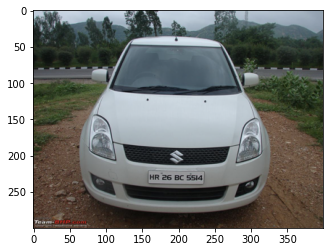

In [19]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
label_id_offset = 1
image_np_with_detections = image_np.copy()
viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [22]:
detection_threshold = 0.7
image = image_np_with_detections
scores = list(filter(lambda x:x>detection_threshold, detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]
width = image.shape[1]
height = image.shape[0]

In [23]:
region_threshold = 0.6
def filter_text(region, ocr_result, region_threshold):
    rectangle_size = region.shape[0]*region.shape[1]
    plate = []
    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        witdh = np.sum(np.subtract(result[0][2], result[0][1]))
        if length*height/rectangle_size>region_threshold:
            plate.append(result[1])
    return plate

In [24]:
def ocr_func(image, detection, detection_threshold, region_threshold):
    scores = list(filter(lambda x:x>detection_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]
    width = image.shape[1]
    height = image.shape[0]
    for idx, box in enumerate(boxes):
        roi = box*[height,width,height,width]
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        reader = easyocr.Reader(['en'])
        ocr_result = reader.readtext(region)
        text = filter_text(region, ocr_result, region_threshold)
        plt.imshow(cv2.cvtColor(region , cv2.COLOR_BGR2RGB))
        print(text)
        return text, region

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['HR 26 BC 5514']


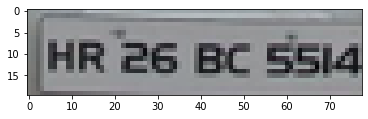

In [28]:
text, region = ocr_func(image_np_with_detections, detections, detection_threshold, region_threshold)

In [30]:
'{}.jpg'.format(uuid.uuid1())

'4b90b010-3be5-11ec-b5cf-04ea56e2f17f.jpg'

In [31]:
def save_results(text, region, csv_filename, folder_path):
    img_name = '{}.jpg'.format(uuid.uuid1())
    cv2.imwrite(os.path.join(folder_path, img_name), region)
    with open(csv_filename, mode='a', newline='') as f:
        csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow([img_name, text])

In [32]:
save_results(text, region, 'detection_results.csv', 'Detection_Images')

# Detection using Webcam

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['DLGCAFL9L3']
['3C6207']


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['OLac m 9e6?', "'30u20786"]


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['0L4 4506-', 'SCGz0786']
['W5c H Du6 ?', 'ZcCz0782']


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['SCLLI78']


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['DLGCAFL9L?']
['DLGCAF 4943']


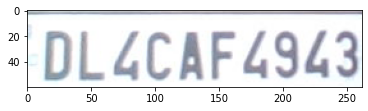

In [36]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)  
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    label_id_offset = 1
    image_np_with_detections = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)
    try:
        text, region = ocr_func(image_np_with_detections, detections, detection_threshold, region_threshold)
    except:
        pass
    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

In [37]:
'{}.jpg'.format(uuid.uuid1())

'60cd8669-3be6-11ec-93fb-04ea56e2f17f.jpg'

In [38]:
save_results(text, region, 'webcam_detection_results.csv', 'Detection_Images')